In [1]:
import netCDF4 as nc
import xarray as xr
from geoarray import GeoArray
from spectral.io import envi
import matplotlib.pyplot as plt
import numpy as np
from isofit.core.common import resample_spectrum
import os
import isofit
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')
from isofit.core.sunposition import sunpos
import holoviews as hv
import hvplot.xarray
from datetime import datetime

C:\Users\vpatro\AppData\Local\anaconda3\envs\isofit_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obs_header = envi.open('../EMIT-scenes/west_africa_scene/emit20230321t150833_o08010_s000_l1b_obs_b0106_v01.hdr')
location_header = envi.open('../EMIT-scenes/west_africa_scene/emit20230321t150833_o08010_s000_l1b_loc_b0106_v01.hdr')
rad_header = envi.open('../EMIT-scenes/west_africa_scene/EMIT_L1B_RAD_001_20230321T150833_2308010_003_radiance.hdr')
mask_header = envi.open('../EMIT-scenes/west_africa_scene/EMIT_L2A_MASK_001_20230321T150833_2308010_003_mask.hdr')

obs_data = obs_header.open_memmap(interleave = 'bip')
loc_data = location_header.open_memmap(interleave = 'bip')
rad_data = rad_header.open_memmap(interleave = 'bip')
mask_data = mask_header.open_memmap(interleave = 'bip')

lat = loc_data[:,:,0]
lon = loc_data[:,:,1]
elev = loc_data[:,:,2]
zenith = obs_data[:,:,4]
zen = np.average(zenith)
zen = np.deg2rad(zen)
es_distance = obs_data[:,:,10]
water_vapor = mask_data[:,:,6]

print('shape of latitude: ', lat.shape)
print('shape of longitude: ', lon.shape)
print('shape of elevation: ', elev.shape)
print('shape of zenith: ', zen.shape)
print('shape of earth-sun distance', es_distance.shape)
print('shape of water vapor: ', water_vapor.shape)

wl = rad_header.metadata['wavelength']
for i in range(len(wl)):
    wl[i] = float(wl[i])
wl = np.array(wl)

fwhm = rad_header.metadata['fwhm']
for i in range(len(fwhm)):
    fwhm[i] = float(fwhm[i])
fwhm = np.array(fwhm)

irr_path = '../irr.npy'
data = np.load(irr_path)
irr_wl = data[:,0]
irr = data[:,1]

#irr = irr / 10  # convert to uW cm-2 sr-1 nm-1
irr_resamp = resample_spectrum(irr, irr_wl, wl, fwhm)
irr_resamp = np.array(irr_resamp, dtype=np.float32)
irr = irr_resamp

print('shape of wavelength: ', wl.shape)
print('shape of fwhm: ', fwhm.shape)
print('shape of irradiance: ', irr.shape)
print('shape of radiance: ', rad_data.shape)

flight_name = rad_header.metadata['flight_line'][0]

year = flight_name[4:8]
month = flight_name[8:10]
date = flight_name[10:12]
hour = flight_name[13:15]
minute = flight_name[15:17]
second = flight_name[17:19]

dt_string = ''
dt_string = dt_string + date + '/' + month + '/' + year + ' ' + hour + ':' + minute + ':' + second

dt = datetime.strptime(dt_string, "%d/%m/%Y %H:%M:%S")
print(dt)

es_path = os.path.join(os.path.dirname(isofit.__file__), "..", "data", "earth_sun_distance.txt")
ref_es = np.loadtxt(es_path)

C:\Users\vpatro\AppData\Local\anaconda3\envs\isofit_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


shape of latitude:  (1280, 1242)
shape of longitude:  (1280, 1242)
shape of elevation:  (1280, 1242)
shape of zenith:  ()
shape of earth-sun distance (1280, 1242)
shape of water vapor:  (1280, 1242)
shape of wavelength:  (285,)
shape of fwhm:  (285,)
shape of irradiance:  (285,)
shape of radiance:  (1280, 1242, 285)
2023-03-21 15:08:33


In [7]:
np.average(es_distance)

0.9960826488891309

In [3]:
import time

start = time.time()
#rho = (np.pi / np.cos(zen)) * (rad_data / irr[np.newaxis, np.newaxis, :])
rho_original = (((rad_data * np.pi) / (irr.T)).T / np.cos(zen)).T
#rhs = (rad_data / irr[np.newaxis, np.newaxis, :])
#rho.shape
#lhs = (np.pi / np.cos(zen))
#print(lhs)
end = time.time()
elapsed = end - start
print(elapsed, ' seconds')

6.4608049392700195  seconds


In [4]:
rho.shape

(1280, 1242, 285)

In [7]:
zen

0.8112507975565805

In [ ]:
plt.plot(rad_data[750,750,:])
plt.show()

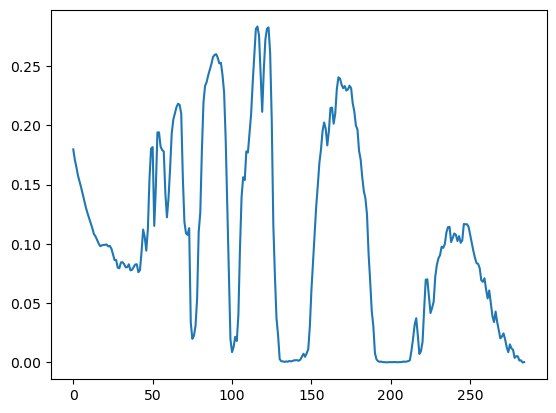

In [5]:
%matplotlib inline
plt.plot(rho_original[750,750,:])
plt.show()

In [2]:
path_list = ['../EMIT-scenes/west_africa_scene/emit20230321t150833_o08010_s000_l1b_obs_b0106_v01.hdr',
             '../EMIT-scenes/west_africa_scene/EMIT_L1B_RAD_001_20230321T150833_2308010_003_radiance.hdr', 
             '../EMIT-scenes/west_africa_scene/EMIT_L2A_MASK_001_20230321T150833_2308010_003_mask.hdr']

irr_path = '../irr.npy'

In [3]:
import preprocess

In [5]:
TOA_refl = preprocess.main(path_list, irr_path)

C:\Users\vpatro\AppData\Local\anaconda3\envs\isofit_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [6]:
TOA_refl.shape

(1280, 1242, 285)

In [7]:
plt.plot(TOA_refl[750,750,:])
plt.show()